# Mapping gene expression in space

This tutorial shows how to use the {class}`~moscot.problems.space.MappingProblem` for transferring gene expression from single-cell data to spatial data.

Mapping single-cell atlases to spatial transcriptomics data is a crucial analysis steps to integrate cell type annotation across technologies. Furthermore, it is often the case that imaging-based spatial transcriptomics technologies only measure a limit set of transcripts, which could be nonetheless used as anchor features to map the gene expression of unobserved genes from single-cell data.

For this purpose, we will use a preprocessed and normalized dataset of the Drosophila embryo, originally used in *NovoSpaRc* {cite}`nitzan:19`. In fact, the {class}`~moscot.problems.space.MappingProblem` is essentially a reimplementation of the original Gromov-Wasserstein formulation from *NovoSpaRc*, yet with a some of technical innovations that makes it more scalable. 

:::{note}
For this tutorial, [Squidpy](https://squidpy.readthedocs.io/en/latest/) is needed for spatial data plotting. You can either install it with:
- `pip install squidpy` or
- `pip install moscot[spatial]` as an optional dependency of {mod}`moscot`
:::

## Imports and data loading

In [1]:
import squidpy as sq
import moscot as mt
import scanpy as sc
from moscot import datasets
from moscot.problems.space import MappingProblem
import seaborn as sns

Load the {func}`~moscots.datasets.drosophila` dataset.

In [2]:
adata_sc = datasets.drosophila(spatial=False)
adata_sp = datasets.drosophila(spatial=True)
adata_sc, adata_sp

(AnnData object with n_obs × n_vars = 1297 × 2000
     obs: 'n_counts'
     var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 3039 × 82
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'log1p', 'pca'
     obsm: 'X_pca', 'spatial'
     varm: 'PCs'
     layers: 'counts')

Let's take a look at the data by plotting couple of summary statistics.

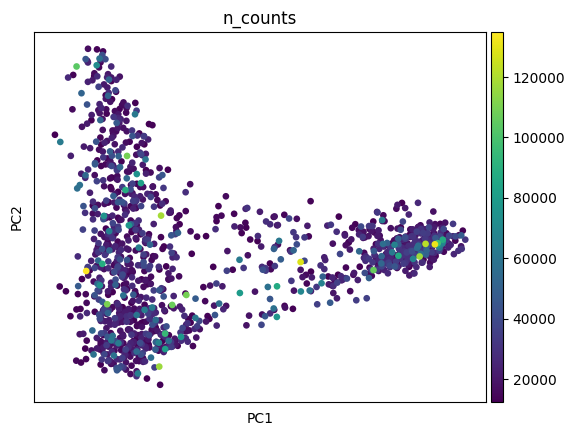

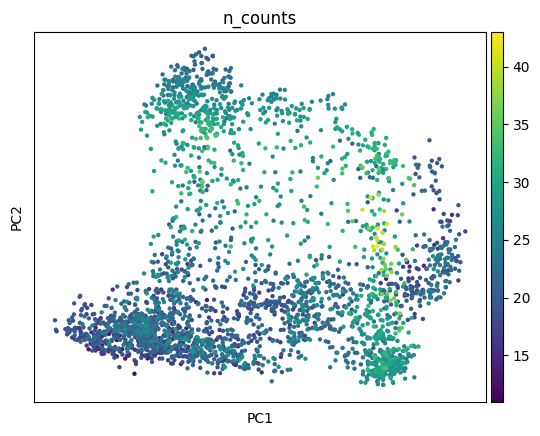

In [3]:
sc.pl.pca(adata_sc, color="n_counts")
sc.pl.pca(adata_sp, color="n_counts")

We can also visualize the spatial dataset in spatial coordinates. Here, it's important to consider that the spatial datasets actually consists of measurements in 3D. We can visualize them with {func}`scanpy.pl.embedding`, as well as with {func}`squidpy.pl.spatial_scatter`.

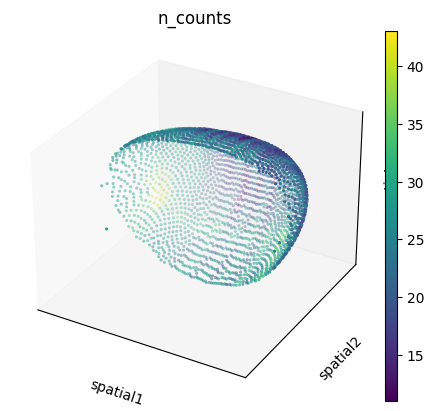

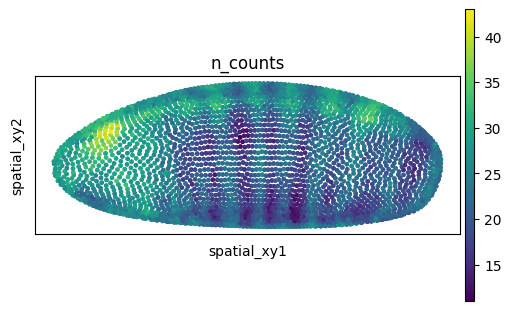

In [4]:
sc.pl.embedding(
    adata_sp,
    basis="spatial",
    color="n_counts",
    projection="3d",
    na_color=(1, 1, 1, 0),
)
adata_sp.obsm["spatial_xy"] = adata_sp.obsm["spatial"][:, [0, 2]]
sq.pl.spatial_scatter(
    adata_sp,
    spatial_key="spatial_xy",
    color="n_counts",
    shape=None,
    size=20,
    figsize=(5, 3),
)

## Mapping single-cell gene expression in space

With {mod}`moscot`, it is possible to learn a single-cell-to-spatial mapping by leveraging Fused Gromov-Wasserstein (FGW) optimal transport {cite}`vayer:2018`. A basic description of the algorithm is the following:

Given a set of observations that share some features in the metric space, and some other features in different metric spaces, the FGW method aims at finding the optimal matching between these two set of observations, based both on shared and unique features. In our case:

- the "shared" metric space could be the one defined by a set of genes that were measured in both single-cell and spatial transcriptomics data.
- the "unique" metric spaces are the genes only measured in single-cell data and the spatial coordinates for the spatial transcriptomics data.

### Prepare the {class}`~moscot.problems.space.MappingProblem`

The moscot {class}`~moscot.problems.space.MappingProblem` interfaces the FGW algorithm in a user-friendly API. First, let's initialize the {class}`~moscot.problems.space.MappingProblem` by passing single-cell and spatial {class}`~anndata.AnnData` objects.

In [5]:
mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp)

After initialization, we need to {meth}`~moscot.problems.space.MappingProblem.prepare` the problem. In this particular case, we need to pay attention to 3 parameters:

- `sc_attr`: specify the attribute in {class}`~anndata.AnnData` that we want to use for the features (genes) in the unique space. Usually, it's the {attr}`~anndata.AnnData.X` attribute, which contains normalized counts, but a pre-computed PCA could also be used.
  Furthermore, for the `unique` features it might be desirable to use some other type of modality, for instance protein expression or ATAC-seq measurements, that could be stored for example in {attr}`~anndata.AnnData.obsm`.
- `var_names`: specify the set of genes that we desire to be using for the `shared` space, that is the common set of genes in both dataset. If set to {obj}`None`, it will try to compute the intersection between
  the single-cell and spatial gene names.
- `joint_attr`: it is possible to also specify some other attributes that might be used for the "shared" features space, for instance, an embedding such as PCA.

If the number of shared features is large enough, it is also possible to compute a PCA on the "shared" gene space (by passing the `callback_kwargs`). We advise this if we are in the settings of $>50$ genes shared between the two datasets.

In [6]:
mp = mp.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"}, kwargs={"callback_kwargs": "local_pca"}
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


### Solve the {class}`~moscot.problems.space.MappingProblem`

We are now ready to {meth}`~moscot.problems.space.MappingProblem.solve` the problem. The most important parameter to take into account is the `alpha` value, which balances the weight of each loss ("unique" vs. "shared" spaces). With alpha close to $0$, the "shared" space loss is weighted more, with alpha close to $1$, the "unique" space loss is balanced more. For the purpose of this example, we'll use `alpha=0.5` but we suggest to increase if only a few features are present. It should take maximum one minute on a laptop.

In [7]:
mp = mp.solve()

INFO     Solving problem OTProblem[stage='prepared', shape=(3039, 1297)].                                          


## Analysis of the transport plan

The first thing we might be interested in doing is "imputing" genes that were not present in the spatial data. We can do so by using the {meth}`~moscot.problems.space.MappingProblem.impute` method.  If you are working on a GPU with large data, you might want to pass `device='cpu'` to the method in order to use the CPU memory for this task. For the purpose of the tutorial, we will select few genes from the single-cell data.

In [8]:
genes = ["cic", "jigr1", "nuse", "scb", "chrb"]
adata_imputed = mp.impute(var_names=genes)

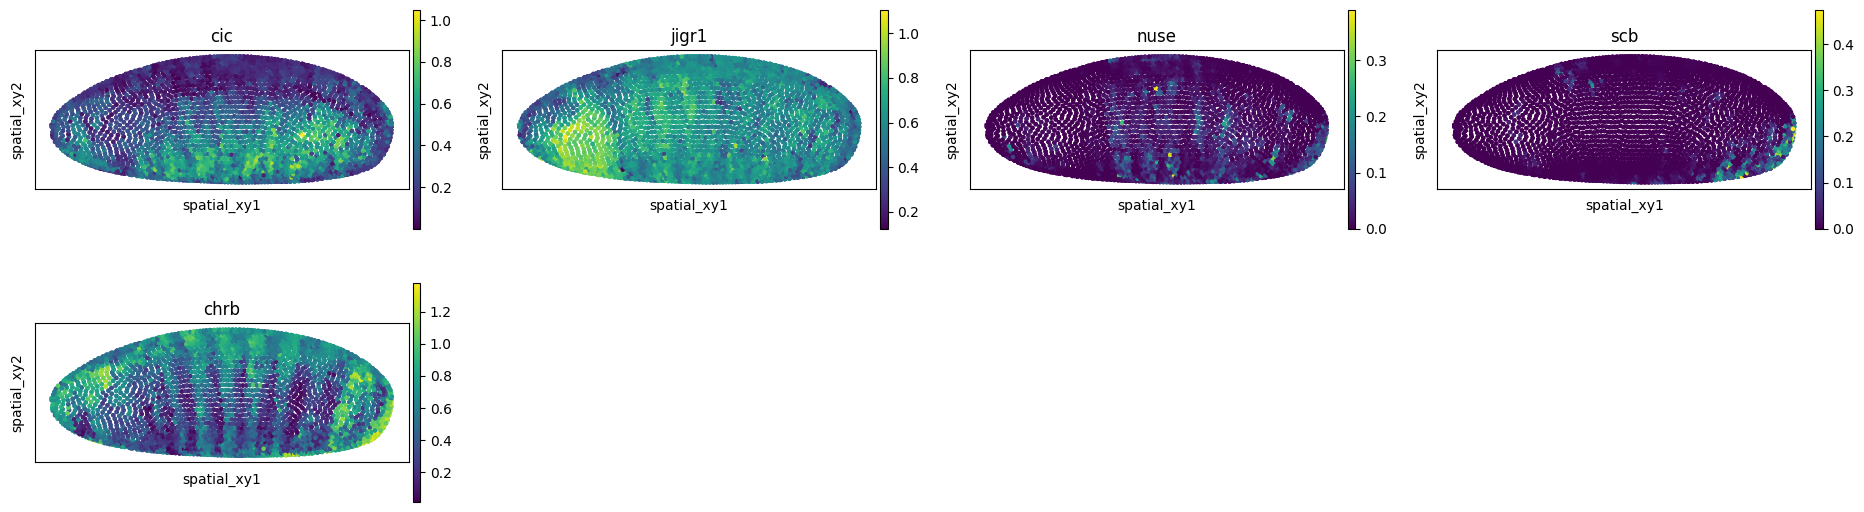

In [9]:
sq.pl.spatial_scatter(
    adata_imputed,
    spatial_key="spatial_xy",
    color=genes,
    shape=None,
    size=20,
    figsize=(5, 3),
)

Another analysis function that we provide is computing gene expression correlation between inferred and ground-truth spatial genes. We can do this with the {meth}`~moscot.problems.space.MappingProblem.correlate` method.

In [10]:
corr = mp.correlate()
corr["src", "tgt"]

ImpL2      0.522811
CenG1A     0.427546
tkv        0.266121
Doc2       0.758132
twi        0.798351
             ...   
bowl       0.553506
cad        0.530229
gt         0.349906
Blimp-1    0.631303
exex       0.386149
Length: 82, dtype: float64

Finally, we provide a helper function to compute "spatial correspondence", that is, the average expression distance at increasing spatial distance, as originally proposed by *NovoSpaRc* {cite}`nitzan:19`. 
If a strong spatial correspondence is observed (as in this case) it can be useful to increase the `alpha` value.

<AxesSubplot: xlabel='index_interval', ylabel='features_distance'>

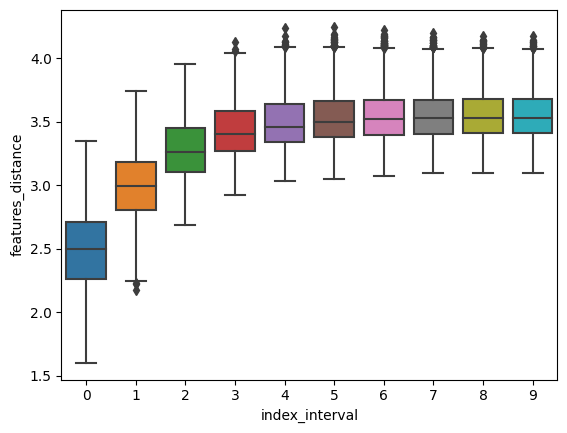

In [11]:
df = mp.spatial_correspondence(max_dist=400)
sns.boxplot(x="index_interval", y="features_distance", data=df)